In [1]:
import jax
from position2 import Position2
from dataclasses import dataclass, field
import numpy as np
import matplotlib.pyplot as plt
from math import *
import scipy.interpolate
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import functools
import jax.random
from flax.optim.adam import Adam
from flax.optim.sgd import GradientDescent

ROS is not sourced. To enable ROS features, please source it


# Load SLAM data

In [2]:
# datafile = "/media/mikhail/Data3T/slam_benchmark/intel.clf"
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" # Corrected intel map
# datafile = "/home/mikhail/Downloads/intel.gfs.log"

In [3]:
@dataclass(frozen=True)
class LaserData(object):
    ranges: np.array
    angles: np.array
    timestamp: float
    odometry_position: Position2
        
    def as_points(self):
        mask = self.ranges < 10
        x = self.ranges[mask] * np.cos(self.angles[mask])
        y = self.ranges[mask] * np.sin(self.angles[mask])
        return np.stack([x, y], axis=1)

    def as_points_in_odometry_frame(self):
        points = self.as_points()
        return self.odometry_position.apply(points)

In [4]:
laser_data_list = []
with open(datafile, "r") as fd:
    for line in fd.readlines():
        line = line.strip()
        tokens = line.split(' ')
        if len(tokens) <= 180:
            continue
        num_scans = int(tokens[1])
        ranges = np.array([float(r) for r in tokens[2:(num_scans + 2)]])
        angles = np.linspace(-90.0 / 180.0 * np.pi, 90.0 / 180.0 * np.pi, num_scans + 1)[:-1]
        timestamp = float(tokens[(num_scans + 8)])
        odom_x, odom_y, odom_theta = [float(r) for r in tokens[(num_scans + 2):(num_scans + 5)]]
        position = Position2(odom_x, odom_y, odom_theta)
        laser_data_list.append(LaserData(ranges=ranges, angles=angles, timestamp=timestamp, odometry_position=
                                        position))

In [5]:
def plot_laser_data_points(laser_data_list, indeces, c=None, s=0.3):
    all_points = []
    for i in range(len(indeces)):
        laser_data = laser_data_list[indeces[i]]
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=s, c=c)

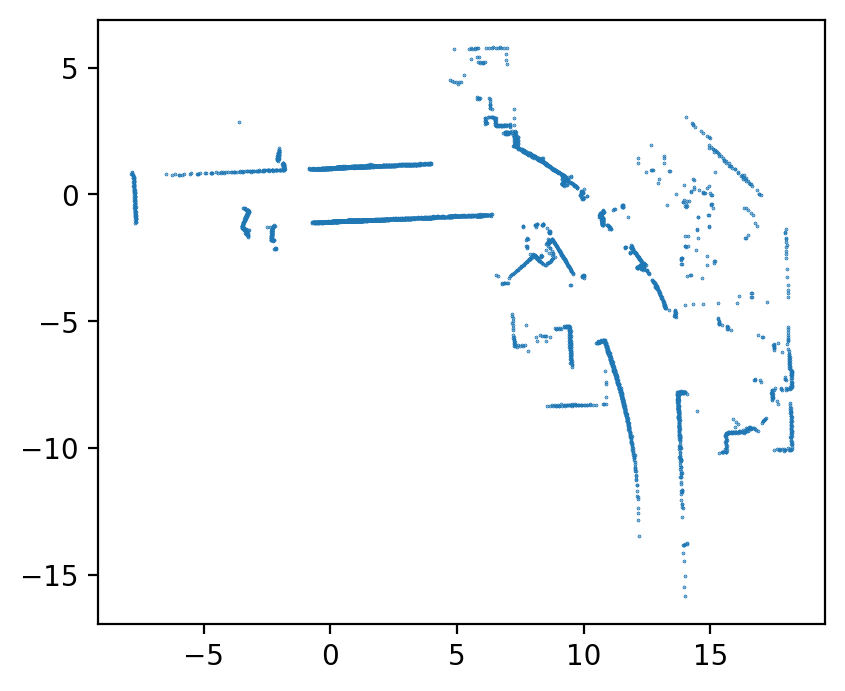

In [6]:
plt.figure(dpi=200)
all_points = []
for laser_data in laser_data_list[:30]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
plt.gca().set_aspect('equal')

# Rendering

In [7]:
class NFModel(nn.Module):
    mean: float
    sigma: float

    @nn.compact
    def __call__(self, x):
        x = (x - self.mean) / self.sigma
        x = nn.Dense(256, use_bias=True)(x)      
        x = jnp.concatenate([jnp.sin(x[:, :128]), jnp.cos(x[:, 128:])], axis=1)
        x1 = x
        x1 = nn.Dense(256)(x1)
        x1 = nn.relu(x1)
#         x1 = nn.Dense(256)(x1)
#         x1 = nn.relu(x1)
        x = jnp.concatenate([x, x1], axis=-1)
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x[:, 0]


In [8]:
def plot_model_heatmap(model, variables, bounds, vmax=None, grid_shape=(100, 100)):
    grid_x, grid_y = jnp.meshgrid(jnp.linspace(bounds[0], bounds[1], 100), 
                                  jnp.linspace(bounds[2], bounds[3], 100))
    grid = jnp.stack([grid_x, grid_y], axis=2).reshape(-1, 2)
    obstacle_probabilites = jax.nn.softplus(model.apply(variables, grid))
    obstacle_probabilites = np.array(obstacle_probabilites).reshape(100, 100)
    grid = grid.reshape(grid_shape[0], grid_shape[1], 2)
    plt.gca().pcolormesh(grid[:, :, 0], grid[:, :, 1], obstacle_probabilites, cmap='RdBu', shading='auto',
                        vmin=0, vmax=None)
    plt.gca().set_aspect('equal')

In [785]:
model = NFModel(0, 0.2)
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
output = model.apply(variables, batch)

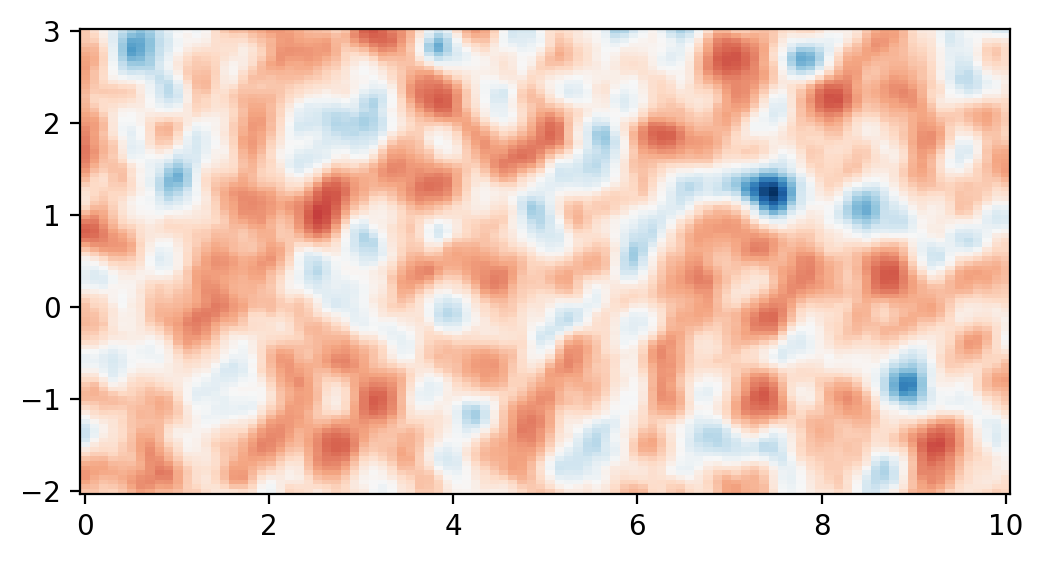

In [786]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (0, 10, -2, 3))

In [787]:
@dataclass(unsafe_hash=True)
class ModelConfig(object):
    minimal_depth: float
    maximal_depth: float
    bins_count: int
    density_scale: float
    variance_weight: float
    depth_delta: float = field(init=False)
    def __post_init__(self):
        self.depth_delta = (self.maximal_depth - self.minimal_depth) / self.bins_count

In [874]:
@jax.jit
def calculate_weights(densities, depth_deltas):
    mis_probability = jnp.exp(-densities * depth_deltas)
    hit_probability = 1 - mis_probability
    mis_probability = jnp.concatenate([jnp.ones(1), mis_probability])
    hit_probability = jnp.concatenate([hit_probability, jnp.ones(1)])
    cumproduct = jnp.cumprod(mis_probability)
    weights = cumproduct * hit_probability
    return weights

@functools.partial(jax.jit, static_argnums=1)
def sample_depth_bins(uniform, parameters):
    depths = jnp.linspace(parameters.minimal_depth, parameters.maximal_depth, parameters.bins_count + 1)[:-1]
    depths = depths + parameters.depth_delta * uniform
    return jnp.concatenate([jnp.full([depths.shape[0], 1], parameters.minimal_depth), 
                            depths, 
                            jnp.full([depths.shape[0], 1], parameters.maximal_depth)], axis=-1)

@jax.jit
def transform_points(points, x, y, angle):
    x = x[..., None]
    y = y[..., None]
    angle = angle[..., None]
    transformed_x = x + points[..., 0] * jnp.cos(angle) - points[..., 1] * jnp.sin(angle)
    transformed_y = y + points[..., 0] * jnp.sin(angle) + points[..., 1] * jnp.cos(angle)
    return jnp.stack([transformed_x, transformed_y], axis=-1)


def calculate_points(depths, angles, angle_deltas):
    x = depths * jnp.cos(angles[..., None] + angle_deltas)
    y = depths * jnp.sin(angles[..., None] + angle_deltas)
    return jnp.stack([x, y], axis=-1)
    
@functools.partial(jax.jit, static_argnums=6)
def loss_function(variables, position, truth_depths, angles, uniform, angle_deltas, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles, angle_deltas)
    points = transform_points(points, position[0], position[1], position[2]).reshape(-1, 2)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    return jnp.mean((truth_depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance + 1e-4) +
                   config.variance_weight * predicted_variance)

In [898]:
@functools.partial(jax.jit, static_argnums=4)
def predict_depths(variables, position, angles, uniform, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles, jnp.zeros((angles.shape[0], config.bins_count + 1)))
    points = transform_points(points, position[0], position[1], position[2]).reshape(-1, 2)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    return predicted_depths

In [899]:
@functools.partial(jax.jit, static_argnums=4)
def predict_normalized_depths(variables, position, angles, uniform, config):
    depth_bins = sample_depth_bins(uniform, config)
    depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
    depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
    points = calculate_points(depths, angles)
    points = transform_points(points, position[0], position[1], position[2]).reshape(-1, 2)
    densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
    weights = jax.vmap(calculate_weights)(densities, depth_deltas)
    extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
    predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
    predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
    return predicted_depths / jnp.sqrt(jax.lax.stop_gradient(predicted_variance + 1e-2))

## Test loss

In [900]:
config = ModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=40,
    density_scale=0.5,
    variance_weight=0.1
)
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
n = 30
position = jnp.ones(3)
angle_deltas = jnp.ones([n, config.bins_count + 1])
loss = loss_function(
    variables, 
    truth_depths=jnp.ones(n), 
    angles=jnp.ones(n), 
    uniform=jnp.ones([n, config.bins_count]),
    position=position,
    angle_deltas=angle_deltas,
    config=config)
print(loss)
grad_function = jax.grad(loss_function)
grad = grad_function( 
    variables, 
    truth_depths=jnp.ones(n), 
    angles=jnp.ones(n), 
    uniform=jnp.ones([n, config.bins_count]),
    position=position,
    angle_deltas=angle_deltas,
    config=config)

1.9009665


In [901]:
index = 6
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
position = jnp.array(laser_data.odometry_position.as_vec())
angle_deltas = jax.random.normal(jax.random.PRNGKey(i), (angles.shape[0], config.bins_count + 1)) * 0.03
loss_function(variables, position, depths, angles, uniform, angle_deltas, config)

DeviceArray(1.7446865, dtype=float32)

In [902]:
2 * np.pi / 180

0.03490658503988659

# Run on one scan

In [1071]:
iterations = 100
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
position = jnp.array(laser_data.odometry_position.as_vec())
batch = jnp.ones([10, 2])
variables = model.init(jax.random.PRNGKey(1), batch)
grad_function = jax.grad(loss_function)
optimizer = Adam(5e-3, beta1=0.9, beta2=0.999)
state = optimizer.init_state(variables)
losses = []
for i in range(iterations):
#     uniform_position_delta = jax.random.normal(jax.random.PRNGKey(i), (3,)) * 0.03
#     rotated_position = jnp.array([position[0], position[1], position[2] + uniform_position_delta[0]])
    rotated_position = position
    angle_deltas = jax.random.normal(jax.random.PRNGKey(i), (angles.shape[0], config.bins_count + 1)) * 0
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    grad = grad_function(variables, rotated_position, depths, angles, uniform, angle_deltas, config)
    loss = loss_function(variables, rotated_position, depths, angles, uniform, angle_deltas, config)
    losses.append(loss)
    variables, state = optimizer.apply_gradient(optimizer.hyper_params, variables, state, grad)
losses[-1]

DeviceArray(0.01370427, dtype=float32)

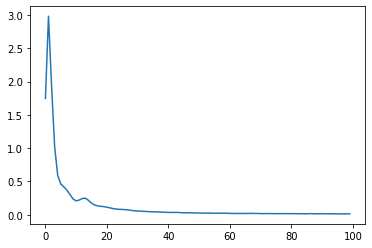

In [1072]:
plt.plot(losses)

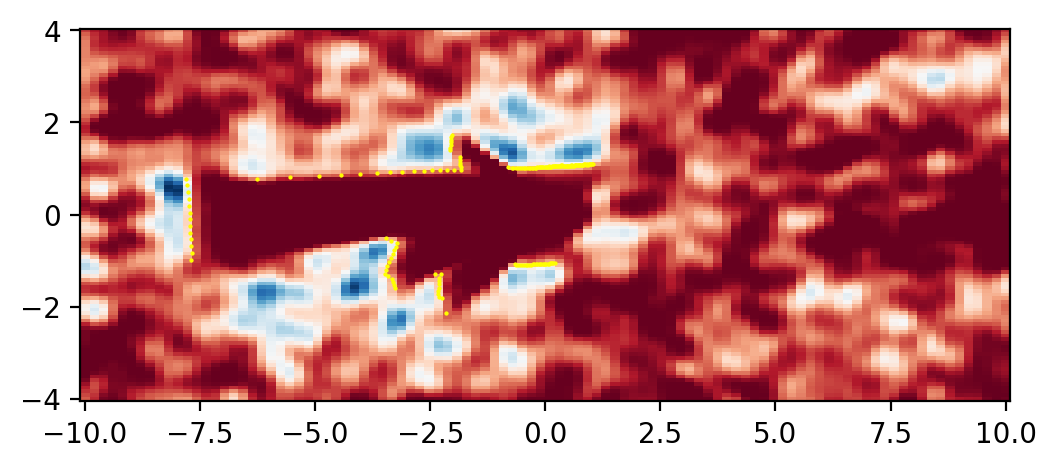

In [1073]:
plt.figure(dpi=200)
plot_model_heatmap(model, variables, (-10, 10, -4, 4))
all_points = []
for laser_data in laser_data_list[index:index + 1]:
    all_points.append(laser_data.as_points_in_odometry_frame())
points = np.concatenate(all_points, axis=0)
plt.scatter(points[:, 0], points[:, 1], s=0.3, c="yellow")
plt.gca().set_aspect('equal')

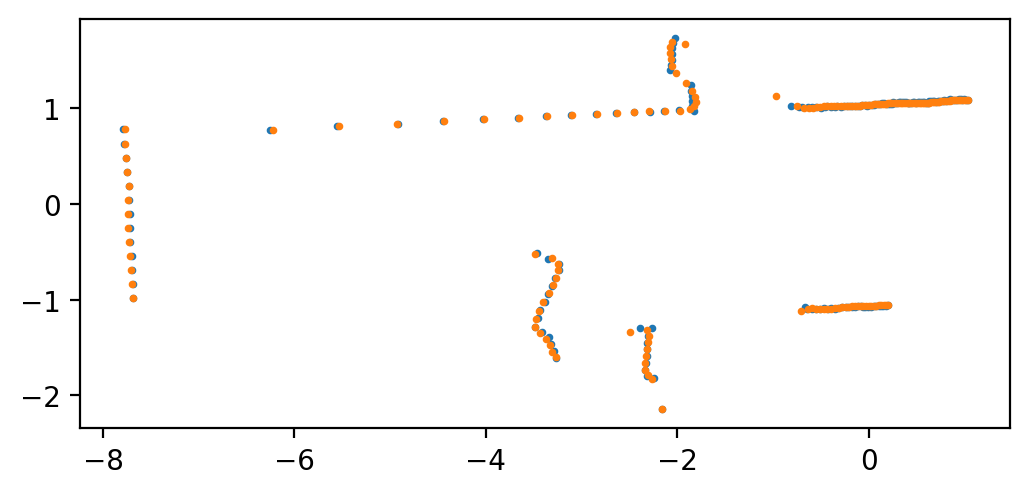

In [1074]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
angles = jnp.array(laser_data.angles[mask])
position = jnp.array(laser_data.odometry_position.as_vec())
# uniform = jax.random.uniform(jax.random.PRNGKey(8), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
predicted_depths = predict_depths(variables, position, angles, uniform, config)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = laser_data.odometry_position.apply(new_points)
plot_laser_data_points(laser_data_list, np.array([index]), s=3)
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
plt.gca().set_aspect('equal')

# Optimize position

In [1075]:
position_grad_function = jax.grad(loss_function, argnums=1)

In [1076]:
iterations = 200
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))

# position = jnp.array(laser_data.odometry_position.as_vec())
# optimized_position = jnp.array([1.3, 0.08, 2.77])
# optimized_position = jnp.array([0.6, 0.08, 1.3])
# optimized_position = jnp.array([0.6, 1., 2.77])
optimized_position = jnp.array([-3, 1., 2.77])

optimizer = Adam(6e-1, beta1=0.8, beta2=0.999)
# optimizer = GradientDescent(2e-3)
state = optimizer.init_state(optimized_position)
losses = []
position_history = [Position2.from_vec(np.array(optimized_position))]
for i in range(iterations):
    uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    grad = position_grad_function(variables, optimized_position, depths, angles, uniform, config)
    loss = loss_function(variables, optimized_position, depths, angles, uniform, config)
    losses.append(loss)
    optimized_position, state = optimizer.apply_gradient(optimizer.hyper_params, optimized_position, state, grad)
    position_history.append(Position2.from_vec(np.array(optimized_position)))
print(losses[-1])
print(optimized_position)
print(laser_data.odometry_position.as_vec())

TypeError: Argument 'ModelConfig(minimal_depth=0.05, maximal_depth=10, bins_count=40, density_scale=0.5, variance_weight=0.1, depth_delta=0.24874999999999997)' of type <class '__main__.ModelConfig'> is not a valid JAX type.

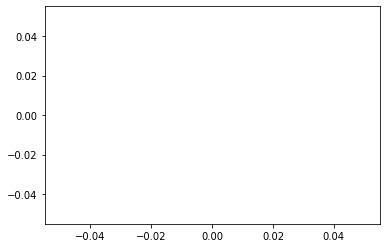

In [1077]:
plt.plot(losses)

In [1078]:
def plot_positions(position_history):
    positions = Position2.from_array(position_history).as_vec()
    plt.plot(positions[:, 0], positions[:, 1])
    plt.quiver(positions[:, 0], positions[:, 1], np.cos(positions[:, 2]), np.sin(positions[:, 2]), scale=25)
    
def plot_position(positions):
    plt.quiver(positions[None, 0], positions[None, 1], np.cos(positions[None, 2]), 
               np.sin(positions[None, 2]), scale=10, color="red")

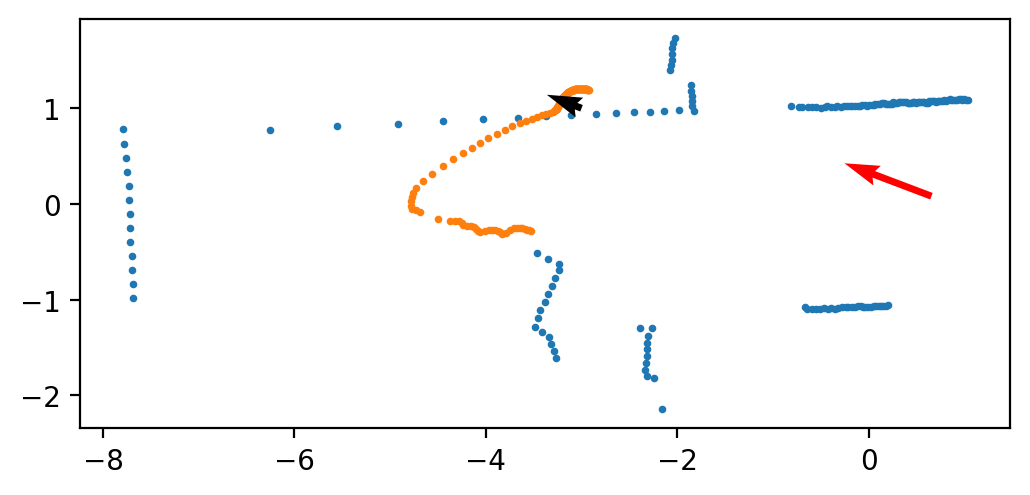

In [1079]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
angles = jnp.array(laser_data.angles[mask])
position = jnp.array(laser_data.odometry_position.as_vec())
# uniform = jax.random.uniform(jax.random.PRNGKey(8), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
predicted_depths = predict_depths(variables, optimized_position, angles, uniform, config)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
new_points = Position2.from_vec(np.array(optimized_position)).apply(new_points)
plot_laser_data_points(laser_data_list, np.array([index]), s=3)
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
plot_positions(position_history)
plot_position(laser_data.odometry_position.as_vec())
plt.gca().set_aspect('equal')

## Hessian

In [1080]:
def huber(input_array, delta):
    mask = jnp.abs(input_array) < delta
    result = jnp.where(mask, input_array ** 2, delta * (2 * jnp.abs(input_array) - delta))
    return jnp.sum(result)

In [1207]:
@functools.partial(jax.jit, static_argnums=5)
def loss_function_without_normalization(variables, position, truth_depths, angles, uniform, config):
#     depth_bins = sample_depth_bins(uniform, config)
#     depths = (depth_bins[..., 1:] + depth_bins[..., :-1]) / 2
#     depth_deltas = (depth_bins[..., 1:] - depth_bins[..., :-1]) / 2
#     points = calculate_points(depths, angles)
#     points = transform_points(points, position[0], position[1], position[2]).reshape(-1, 2)
#     densities = config.density_scale * jax.nn.softplus(model.apply(variables, points)).reshape(depths.shape[:2])
#     weights = jax.vmap(calculate_weights)(densities, depth_deltas)
#     extended_depths = jnp.concatenate([depths, jnp.full([depths.shape[0], 1], config.maximal_depth)], axis=-1)
#     predicted_depths = jnp.sum(weights * extended_depths, axis=-1)
#     predicted_variance = jnp.sum(weights * (extended_depths - predicted_depths[..., None]) ** 2, axis=-1)
#     return jnp.sum((truth_depths - predicted_depths) ** 2 / jax.lax.stop_gradient(predicted_variance + 1e-4))
    delta = 0.007
    predicted_depths0 = predict_depths(variables, position, angles, uniform, config)
#     predicted_depths1 = predict_depths(variables, position, angles + delta, uniform, config)
#     predicted_depths2 = predict_depths(variables, position, angles - delta, uniform, config)
#     predicted_depths3 = predict_depths(variables, position, angles + 2 * delta, uniform, config)
#     predicted_depths4 = predict_depths(variables, position, angles - 2 * delta, uniform, config)
#     predicted_depths = (6 * predicted_depths0 + 4 * predicted_depths1 + 4 *  predicted_depths2 + predicted_depths3 +\
#         predicted_depths4) / 16
    return jnp.sum(((truth_depths - predicted_depths0) ** 2))
#     return huber(truth_depths - predicted_depths, 0.3)

In [1208]:
np.pi / 360

0.008726646259971648

In [1209]:
partial_predict_depths = functools.partial(predict_depths, config=config)
jacobian_function = jax.jacfwd(partial_predict_depths, argnums=1)

In [1865]:
position_grad_function = jax.grad(functools.partial(loss_function_without_normalization, config=config), argnums=1)
iterations = 100
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))

# position = jnp.array(laser_data.odometry_position.as_vec())
# optimized_position = jnp.array([-3, 1., 2.77])
# optimized_position = jnp.array([0.656, 0.0812, 2])
# optimized_position = jnp.array([0.6, 0.08, -2])
optimized_position = jnp.array([0, -1, 2.7])
# optimized_position = jnp.array(laser_data_list[7].odometry_position.as_vec())
# optimized_position = jnp.array(laser_data_list[3].odometry_position.as_vec())
print(optimized_position)

losses = []
position_history = [Position2.from_vec(np.array(optimized_position))]
# uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
# uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
for i in range(iterations):
#     uniform = jax.random.uniform(jax.random.PRNGKey(i), (len(depths), config.bins_count))
    grad = loss_clip_grads(variables, optimized_position, depths, angles, uniform, config)
#     grad = position_grad_function(variables, optimized_position, depths, angles, uniform)
    jacobian = jacobian_function(variables, optimized_position, angles, uniform)
#     jacobian = jnp.clip(jacobian, -50, 50)
    clip_grads = jnp.clip(jacobian, -40, 40)
    matrix = jnp.array([[1, 1, 0], [1, 1, 0], [0, 0, 1]])
    jacobian = jnp.stack([jacobian[:, 0], jacobian[:, 1], clip_grads[:, 2]], axis=1)
    hessian = 2 * jacobian.T @ jacobian  + jnp.diag(jnp.array([20, 20, 200]))
#     print(hessian)
    delta = -jnp.linalg.inv(hessian) @ grad
#     delta = -1 / hessian[2, 2] * grad
#     delta = -0.0001 * grad
#     print(delta)
#     print(grad)
#     print(hessian)
#     delta = jnp.array([ 0.1 * delta[0],  0.1 * delta[1], delta[2]])
    optimized_position = optimized_position + delta
    loss = loss_function_without_normalization(variables, optimized_position, depths, angles, uniform, config)
    losses.append(loss)
    position_history.append(Position2.from_vec(np.array(optimized_position)))
print(losses[-1])
print(optimized_position)
print(laser_data.odometry_position.as_vec())
print(hessian)
print(grad)
print(delta)
# print(depths - predict_depths(variables, optimized_position, angles, uniform, config))

[ 0.  -1.   2.7]
0.12866223
[0.65693086 0.08352301 2.7806864 ]
[0.656165  0.0812728 2.77968  ]
[[  605.8164    548.03217  -936.0476 ]
 [  548.03217  2813.1443  -7200.3525 ]
 [ -936.0476  -7200.3525  23879.352  ]]
[8.7261200e-05 1.3685226e-04 1.6212463e-05]
[-6.3643533e-08 -1.9442632e-07 -6.1799163e-08]


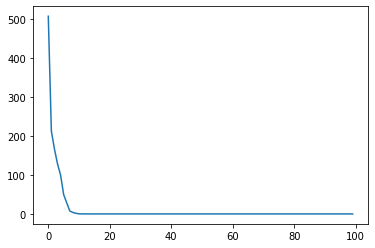

In [1866]:
plt.plot(losses)

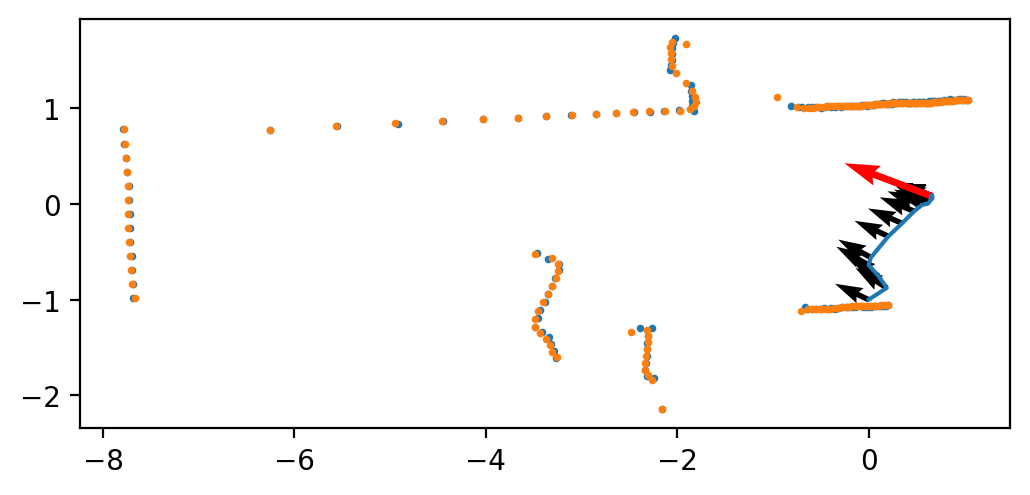

In [1867]:
plt.figure(dpi=200)
index = learning_index
# index = 8
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
angles = jnp.array(laser_data.angles[mask])
position = jnp.array(laser_data.odometry_position.as_vec())
# uniform = jax.random.uniform(jax.random.PRNGKey(8), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
predicted_depths = predict_depths(variables, optimized_position, angles, uniform, config)
new_points = np.stack([np.cos(angles) * predicted_depths, np.sin(angles) * predicted_depths], axis=1)
# new_points = Position2.from_vec(np.array(optimized_position)).apply(new_points)
new_points = laser_data.odometry_position.apply(new_points)
plot_laser_data_points(laser_data_list, np.array([index]), s=3)
plt.scatter(new_points[:, 0], new_points[:, 1], s=3)
plot_positions(position_history)
plot_position(laser_data.odometry_position.as_vec())
plt.gca().set_aspect('equal')

# Loss function for rotation

In [1219]:
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
# position_angles = jnp.linspace(2, 2.77, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
losses = []
for angle in position_angles:
    rotated_position = jnp.array([position[0], position[1], angle])
    loss = loss_function_without_normalization(variables, rotated_position, depths, angles, uniform, config)
    losses.append(loss)

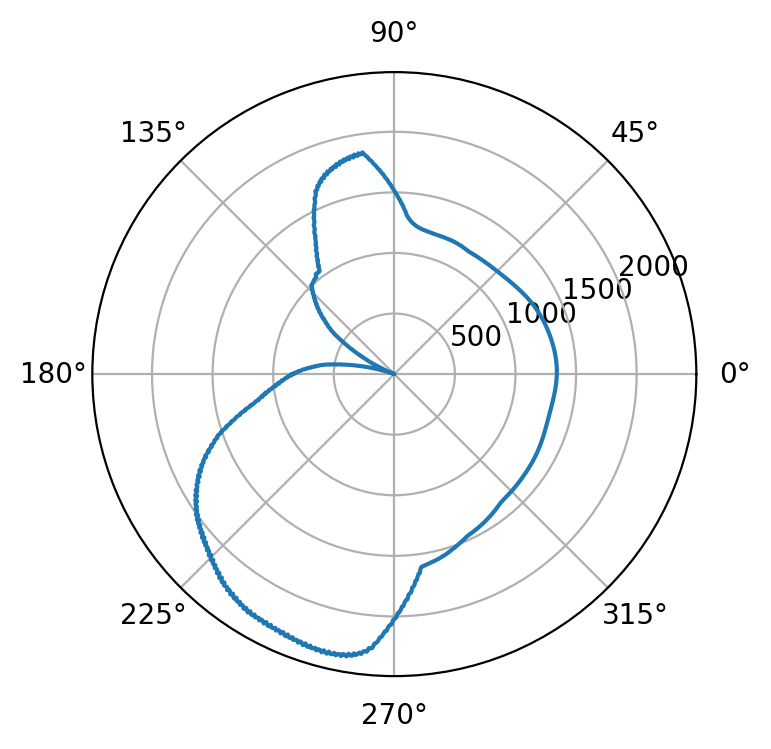

In [1220]:
plt.figure(dpi=200)
plt.polar(position_angles, losses)

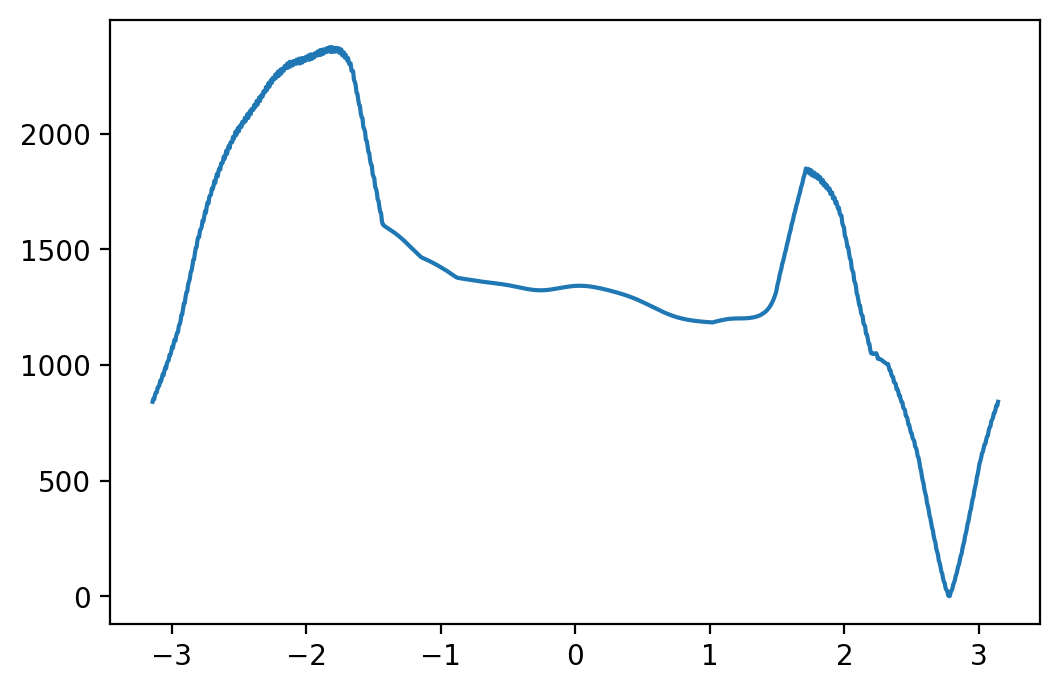

In [1221]:
plt.figure(dpi=200)
plt.plot(position_angles, losses)

In [1322]:
position_grad_function = jax.grad(functools.partial(loss_function_without_normalization, config=config), argnums=1)
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
# position_angles = jnp.linspace(2, 3, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
# mask = (laser_data.ranges < 10) & (np.arange(180) % 3 == 0)
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
grads = []
for angle in position_angles:
    rotated_position = jnp.array([position[0], position[1], angle])
    angle_deltas = jax.random.normal(jax.random.PRNGKey(0), (angles.shape[0],)) * 0.03
    grad = position_grad_function(variables, rotated_position, depths, angles, uniform)
    grads.append(grad[2])

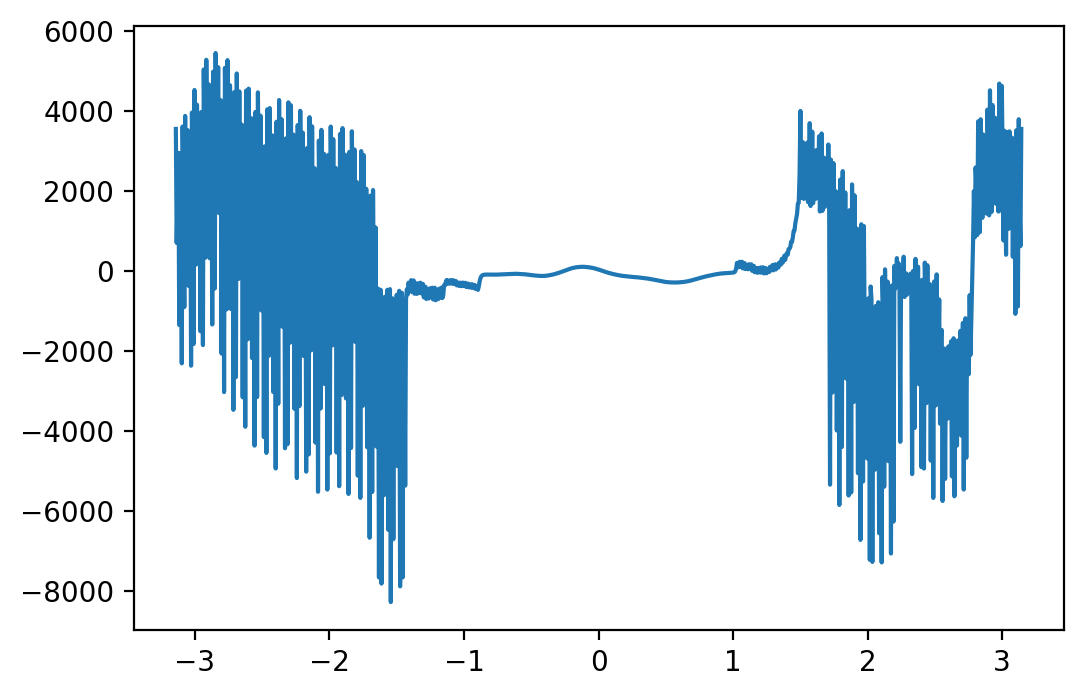

In [1323]:
plt.figure(dpi=200)
plt.plot(position_angles, grads)

In [1243]:
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
# position_angles = jnp.linspace(-1.6, -1.45, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
predict_depths(variables, position, angles, uniform, config)
predicted_depths = []
for angle in position_angles:
    rotated_position = jnp.array([position[0], position[1], angle])
    depth = predict_depths(variables, rotated_position, angles, uniform, config)
    predicted_depths.append(depth[0])

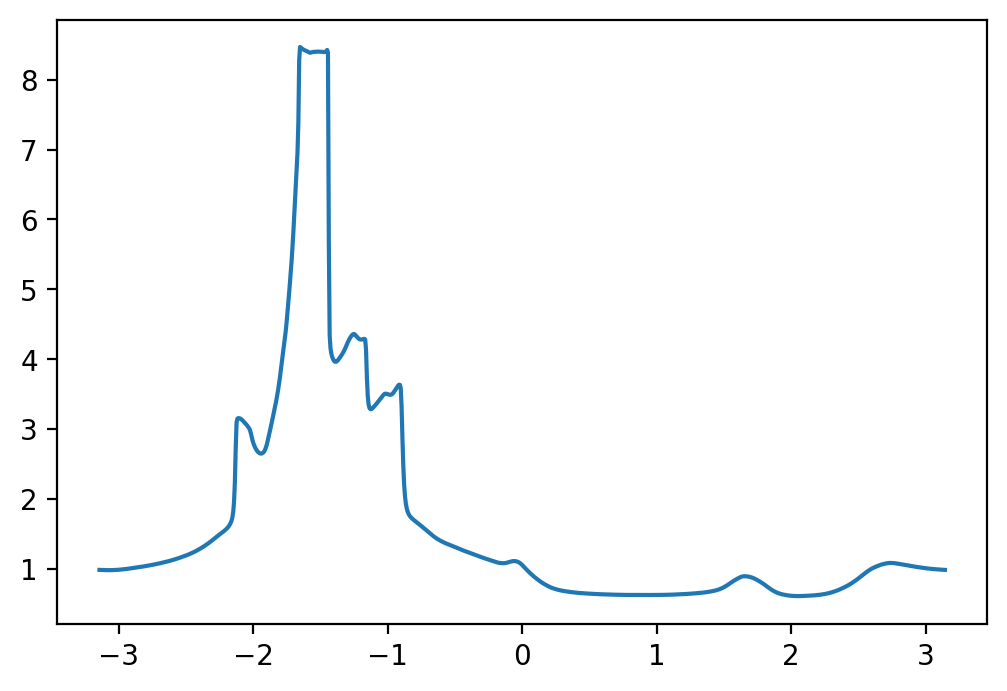

In [1244]:
plt.figure(dpi=200)
# plt.plot(position_angles[1:], np.array(predicted_depths)[1:] - np.array(predicted_depths)[:-1])
plt.plot(position_angles, predicted_depths)

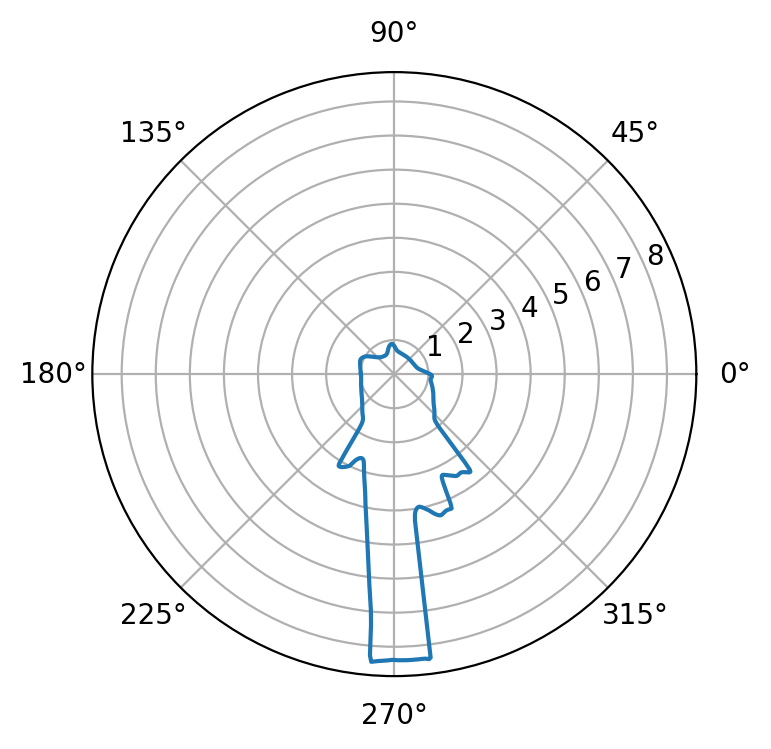

In [1245]:
plt.figure(dpi=200)
plt.polar(position_angles, predicted_depths)

In [1246]:
def depth_sum(variables, rotated_position, angles, uniform, config):
    return jnp.sum(predict_depths(variables, rotated_position, angles, uniform, config)[0])

depth_grad_function = jax.grad(functools.partial(depth_sum, config=config), argnums=1)

# position_angles = jnp.linspace(2, 3, 1000)
position_angles = jnp.linspace(-np.pi, np.pi, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
# mask = (laser_data.ranges < 10) & (np.arange(180) % 3 == 0)
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
grads = []
for angle in position_angles:
    rotated_position = jnp.array([position[0], position[1], angle])
#     angle_deltas = jax.random.normal(jax.random.PRNGKey(0), (angles.shape[0],)) * 0.03
    grad = depth_grad_function(variables, rotated_position, angles, uniform)
    grads.append(grad[2])

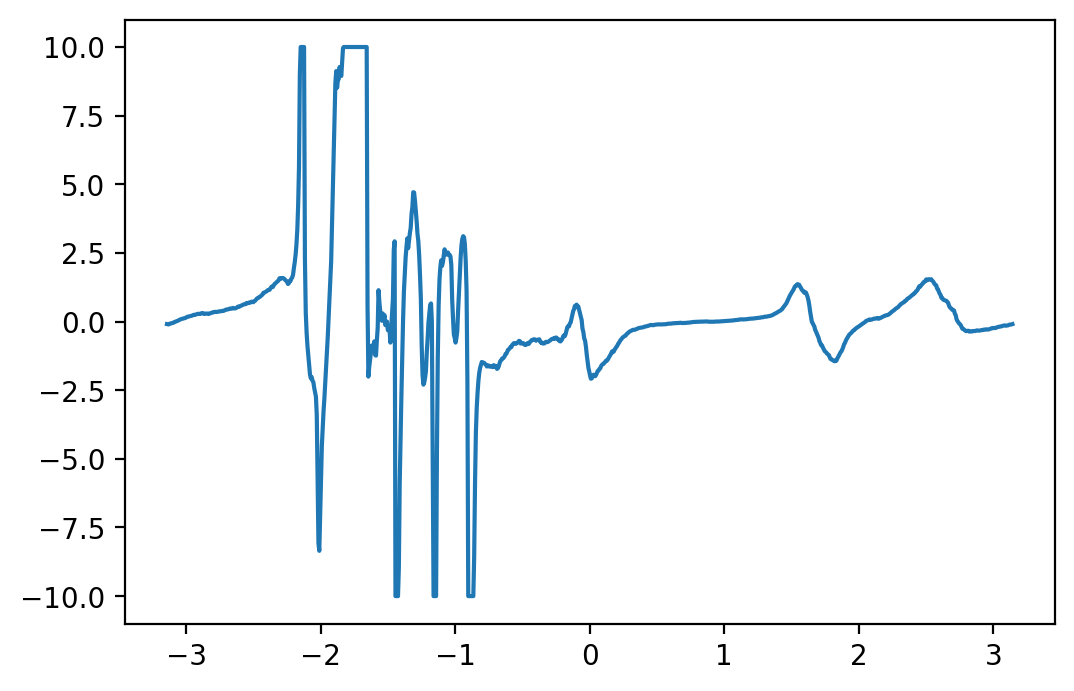

In [1247]:
plt.figure(dpi=200)
plt.plot(position_angles, jnp.clip(jnp.array(grads), -10, 10))

<PolarAxesSubplot:>

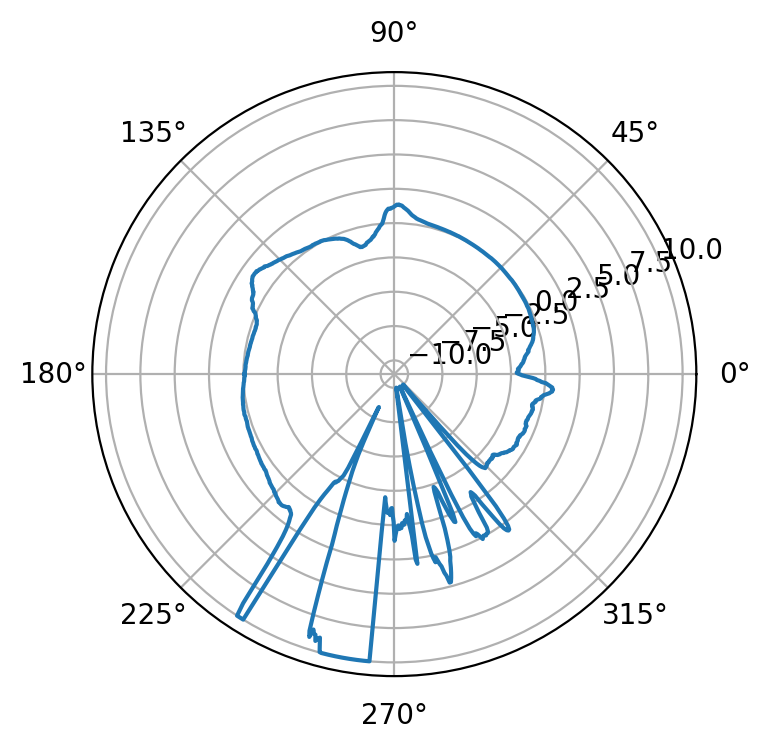

In [1252]:
plt.figure(dpi=200)
plt.polar(position_angles, jnp.clip(jnp.array(grads), -10, 10))


In [1271]:
import tqdm

In [1730]:
depth_jacobian_function = jax.jacfwd(functools.partial(predict_depths, config=config), argnums=1)

@functools.partial(jax.jit, static_argnums=5)
def loss_clip_grads(variables, position, truth_depths, angles, uniform, config):
    predicted_depths = predict_depths(variables, position, angles, uniform, config)
    jacobian = depth_jacobian_function(variables, position, angles, uniform)
    clip_grads = jnp.clip(jacobian, -40, 40)
    clip_grads = jnp.stack([jacobian[:, 0], jacobian[:, 1], clip_grads[:, 2]], axis=1)
    return 2 * jnp.sum(clip_grads * (predicted_depths - truth_depths)[:, None], axis=0)

In [1731]:
loss_clip_grads

<CompiledFunction of <function loss_clip_grads at 0x7f17a42d41f0>>

In [1732]:
position_angles = jnp.linspace(2, 3, 1000)
# position_angles = jnp.linspace(-np.pi, np.pi, 1000)
index = 6
learning_index = index
laser_data = laser_data_list[index]
mask = laser_data.ranges < 10
depths = jnp.array(laser_data.ranges[mask])
angles = jnp.array(laser_data.angles[mask])
# uniform = jax.random.uniform(jax.random.PRNGKey(5), (len(depths), config.bins_count))
uniform = jnp.ones((angles.shape[0], config.bins_count)) * 0.5
position = jnp.array(laser_data.odometry_position.as_vec())
norm_grads = []
for angle in tqdm.tqdm(position_angles):
    rotated_position = jnp.array([position[0], position[1], angle])
    norm_grad = loss_clip_grads(variables, rotated_position, depths, angles, uniform, config)
    norm_grads.append(norm_grad[2])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.18it/s]


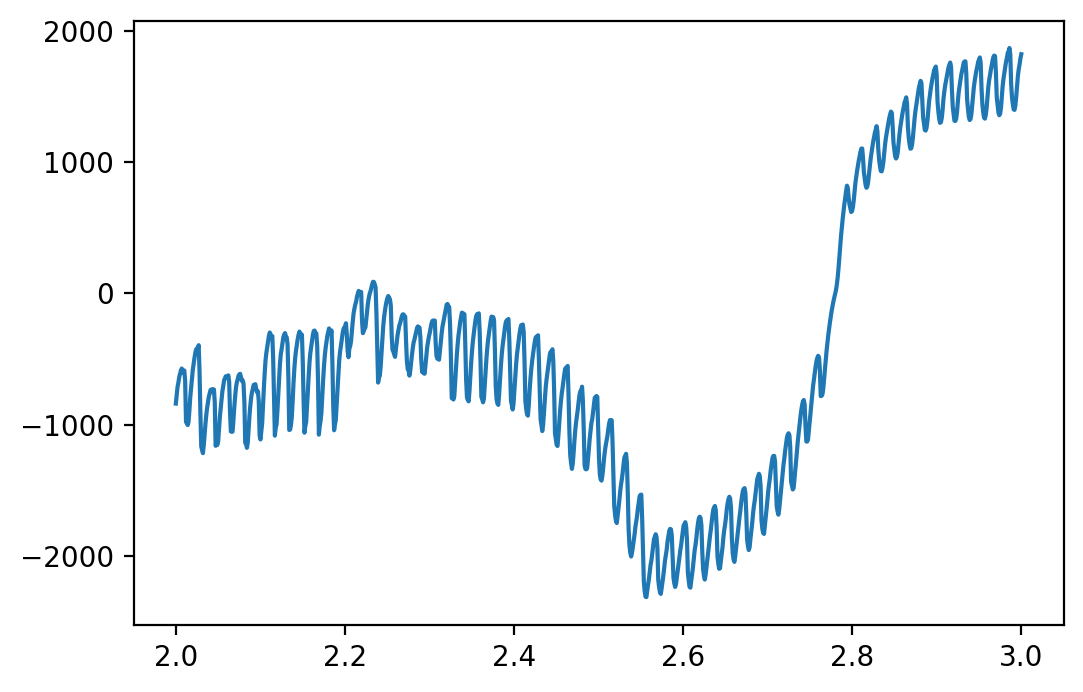

In [1733]:
plt.figure(dpi=200)
# plt.plot(position_angles, grads)
plt.plot(position_angles, norm_grads)
